# Análisis Exploratorio de la Inmigración y Criminalidad en España

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

def load_and_clean(path, sep=','):
    df = pd.read_csv(path, sep=sep)
    if 'Total' in df.columns:
        df['Total'] = pd.to_numeric(df['Total'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False), errors='coerce')
        df['Total'] = df['Total'].fillna(0)
    return df

base_path = "../datos"
activos = load_and_clean(f"{base_path}/activos_nacionalidad_sexo_edad.csv")
empleo = load_and_clean(f"{base_path}/tasa_de_empleo_anual.csv", sep=';')
delitos = load_and_clean(f"{base_path}/delitos_nacionalidad.csv")
condenados = load_and_clean(f"{base_path}/condenados_sexo_nacionalidad_numero_delitos.csv")
ocupados = load_and_clean(f"{base_path}/ocupados_nacionalidad_sector.csv")
poblacion = load_and_clean(f"{base_path}/poblacion_pais_nacimiento.csv")
salario = load_and_clean(f"{base_path}/salarios_jornada_nacionalidad_decil.csv")
delito_sexual = load_and_clean(f"{base_path}/delitos_sexuales_nacionalidad.csv", sep=';')
paro = load_and_clean(f"{base_path}/paro_por_nacionalidad.csv", sep=';')
paro["periodo"] = pd.to_numeric(paro["periodo"].astype(str).str.replace('*', '', regex=False), errors="coerce")
neet = load_and_clean(f"{base_path}/no_estudian_ni_trabajan_por_nacionalidad.csv", sep=';')
pobreza = load_and_clean(f"{base_path}/riesgo_de_pobreza_nacionalidad.csv", sep=';')


## Regresión: Crímenes vs Población Extranjera

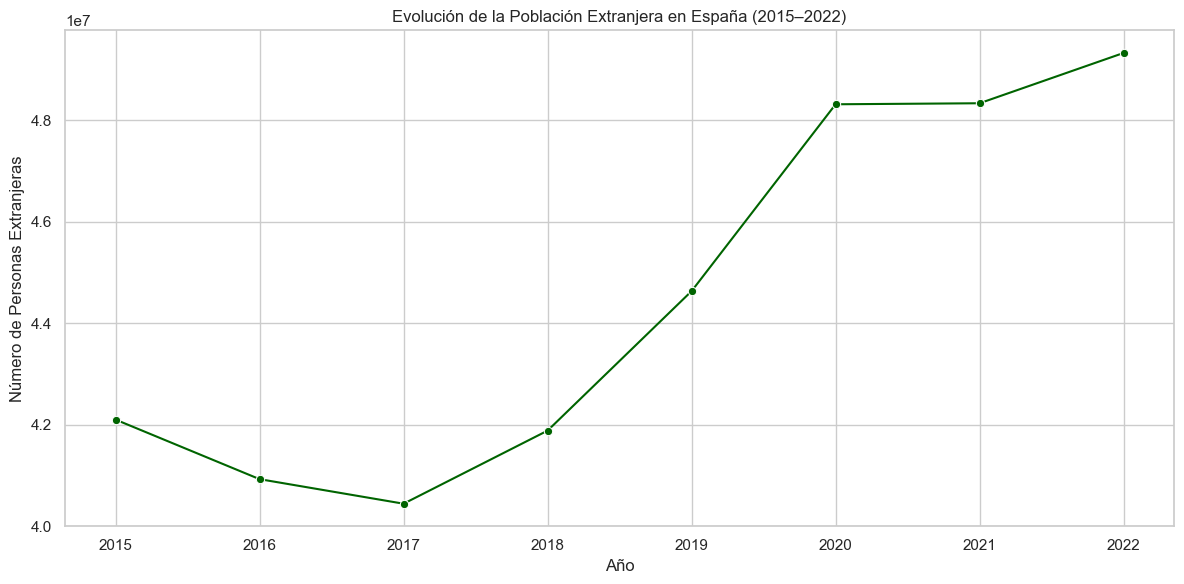

In [3]:
# Asegurar limpieza
poblacion["Español/Extranjero"] = poblacion["Español/Extranjero"].str.strip().str.lower()
extranjera = poblacion[poblacion["Español/Extranjero"] == "nacionalidad extranjera"].copy()
extranjera["Total"] = pd.to_numeric(extranjera["Total"], errors="coerce")

# Agrupar por año
poblacion_agg = (
    extranjera.groupby("Año")["Total"]
    .sum()
    .reset_index()
)

# Filtrar desde 2015
poblacion_agg_filtrada = poblacion_agg[poblacion_agg["Año"] >= 2015]

# Graficar
sns.lineplot(data=poblacion_agg_filtrada, x="Año", y="Total", marker="o", color="darkgreen")
plt.title("Evolución de la Población Extranjera en España (2015–2022)")
plt.xlabel("Año")
plt.ylabel("Número de Personas Extranjeras")
plt.grid(True)
plt.tight_layout()
plt.show()


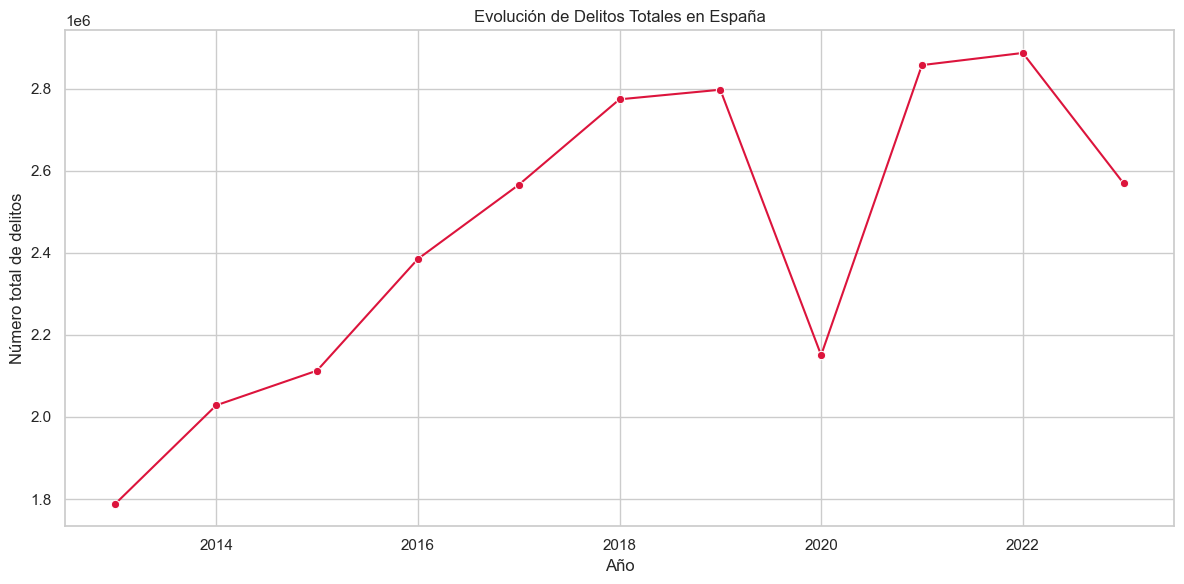

In [4]:
# Convertir 'Total' a numérico si no lo está ya
delitos["Total"] = pd.to_numeric(delitos["Total"], errors="coerce")

delitos_totales = (
    delitos.groupby("Periodo")["Total"]
    .sum()
    .reset_index()
    .rename(columns={"Periodo": "Año"})
)

sns.lineplot(data=delitos_totales, x="Año", y="Total", marker='o', color="crimson")
plt.title("Evolución de Delitos Totales en España")
plt.xlabel("Año")
plt.ylabel("Número total de delitos")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
'''def grafica1(data1):
    sns.lineplot(data=data1, x="Año", y="Total", marker="o", color="darkgreen")
    plt.title("Evolución de la Población Extranjera en España (2015–2022)")
    plt.xlabel("Año")
    plt.ylabel("Número de Personas Extranjeras")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../Visualizaciones/gráficalineplot1.jpg')
def grafica2(data2):
    sns.lineplot(data=data2, x="Año", y="Total", marker='o', color="crimson")
    plt.title("Evolución de Delitos Totales en España")
    plt.xlabel("Año")
    plt.ylabel("Número total de delitos")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../Visualizaciones/gráficalineplot2.jpg')
'''


'def grafica1(data1):\n    sns.lineplot(data=data1, x="Año", y="Total", marker="o", color="darkgreen")\n    plt.title("Evolución de la Población Extranjera en España (2015–2022)")\n    plt.xlabel("Año")\n    plt.ylabel("Número de Personas Extranjeras")\n    plt.grid(True)\n    plt.tight_layout()\n    plt.savefig(\'../Visualizaciones/gráficalineplot1.jpg\')\ndef grafica2(data2):\n    sns.lineplot(data=data2, x="Año", y="Total", marker=\'o\', color="crimson")\n    plt.title("Evolución de Delitos Totales en España")\n    plt.xlabel("Año")\n    plt.ylabel("Número total de delitos")\n    plt.grid(True)\n    plt.tight_layout()\n    plt.savefig(\'../Visualizaciones/gráficalineplot2.jpg\')\n'

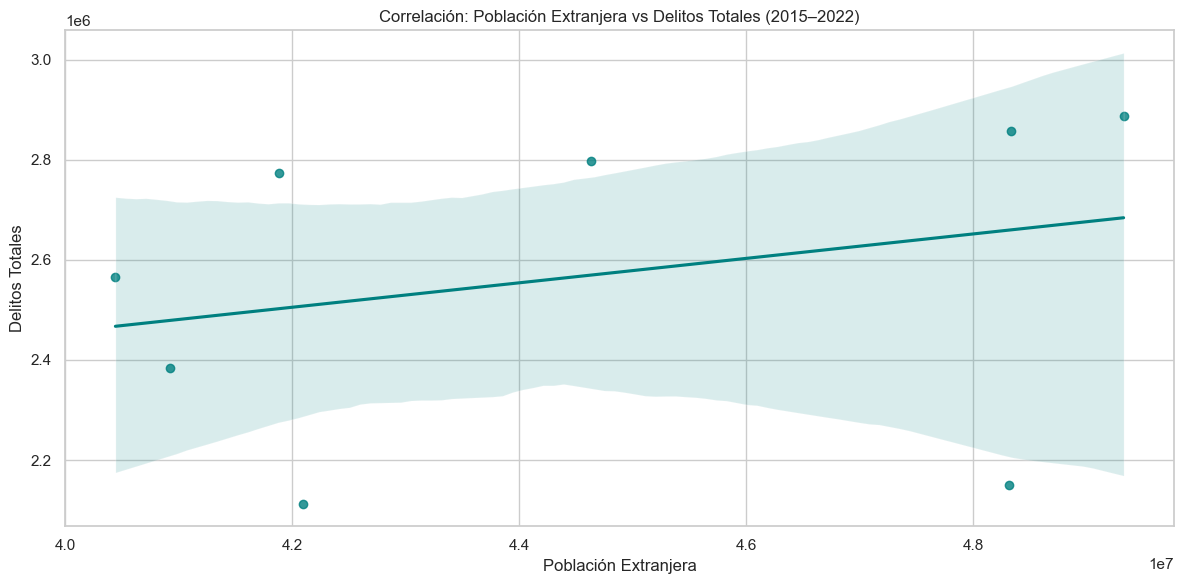

In [6]:
# Unir datasets por año
df_corr = pd.merge(poblacion_agg_filtrada.rename(columns={"Total": "PoblacionExtranjera"}), 
                   delitos_totales.rename(columns={"Total": "DelitosTotales"}), 
                   on="Año", how="inner")

# Gráfico de regresión
sns.regplot(data=df_corr, x="PoblacionExtranjera", y="DelitosTotales", color="teal", marker="o")
plt.title("Correlación: Población Extranjera vs Delitos Totales (2015–2022)")
plt.xlabel("Población Extranjera")
plt.ylabel("Delitos Totales")
plt.grid(True)
plt.tight_layout()
plt.show()


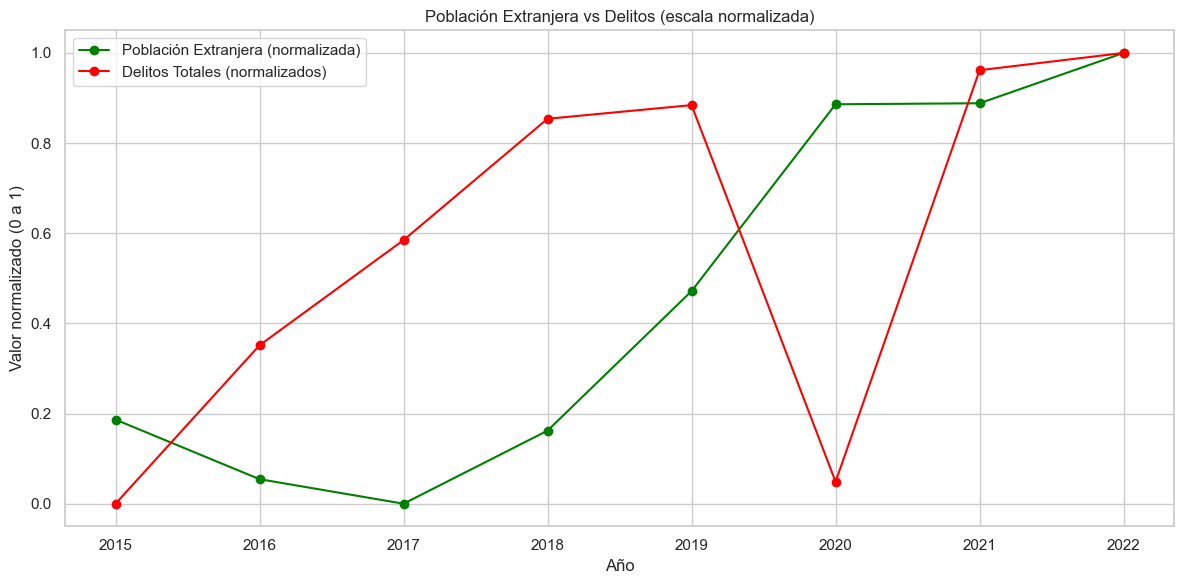

In [7]:
# Normalizar ambas variables
df_scaled = df_corr.copy()
df_scaled["PoblacionNorm"] = (df_scaled["PoblacionExtranjera"] - df_scaled["PoblacionExtranjera"].min()) / (df_scaled["PoblacionExtranjera"].max() - df_scaled["PoblacionExtranjera"].min())
df_scaled["DelitosNorm"] = (df_scaled["DelitosTotales"] - df_scaled["DelitosTotales"].min()) / (df_scaled["DelitosTotales"].max() - df_scaled["DelitosTotales"].min())

# Graficar en misma escala
import matplotlib.pyplot as plt

plt.plot(df_scaled["Año"], df_scaled["PoblacionNorm"], marker="o", label="Población Extranjera (normalizada)", color="green")
plt.plot(df_scaled["Año"], df_scaled["DelitosNorm"], marker="o", label="Delitos Totales (normalizados)", color="red")
plt.title("Población Extranjera vs Delitos (escala normalizada)")
plt.xlabel("Año")
plt.ylabel("Valor normalizado (0 a 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


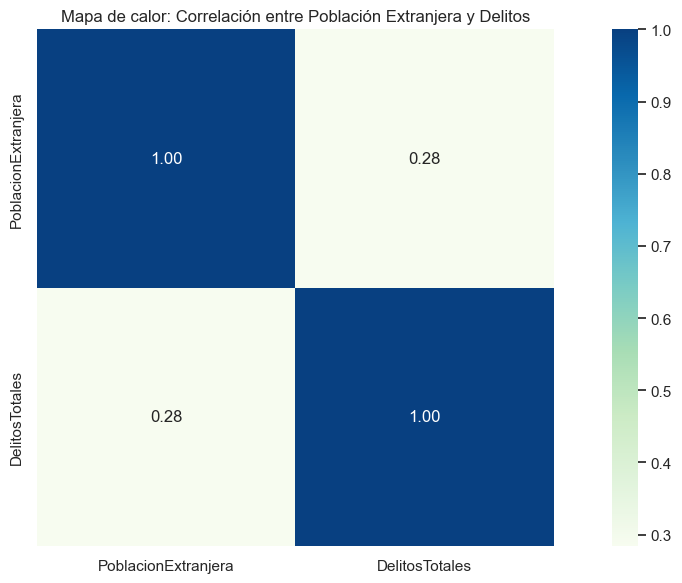

In [8]:
correlacion = df_corr[["PoblacionExtranjera", "DelitosTotales"]].corr()

sns.heatmap(correlacion, annot=True, cmap="GnBu", fmt=".2f", square=True)
plt.title("Mapa de calor: Correlación entre Población Extranjera y Delitos")
plt.tight_layout()
plt.show()


## Condenados por Nacionalidad

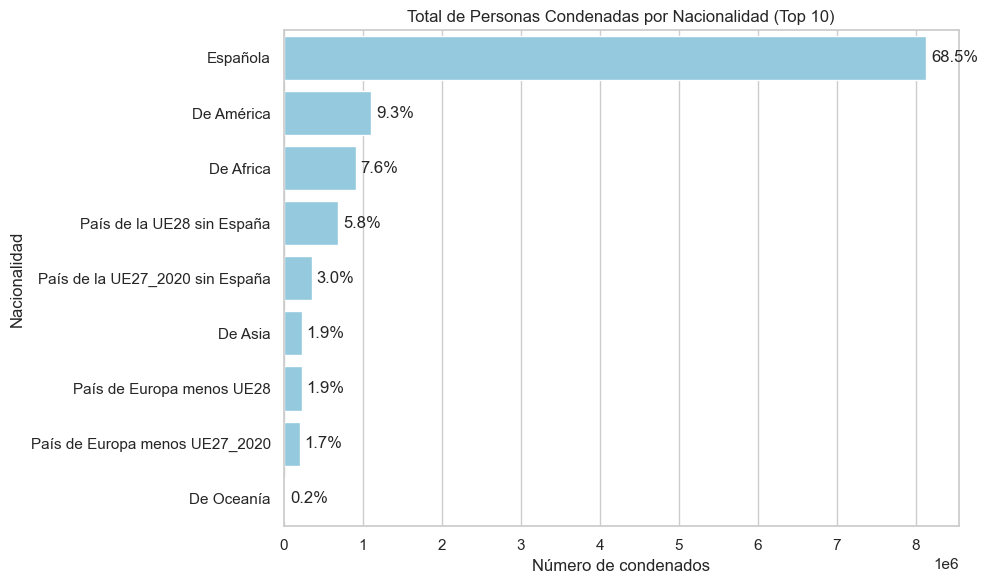

In [9]:
agg = (
    condenados.groupby("Nacionalidad")["Total"]
    .sum()
    .reset_index()
    .sort_values("Total", ascending=False)
)
# Eliminar la fila "Total" si existe
agg = agg[agg["Nacionalidad"].str.lower() != "total"]

# Total global
total_general = agg["Total"].sum()

# Calcular top 10 y porcentaje global
top10 = agg.sort_values("Total", ascending=False).head(10)
top10["Porcentaje"] = (top10["Total"] / total_general) * 100

# Graficar
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10, x="Total", y="Nacionalidad", color="skyblue")

for i, (total, porcentaje) in enumerate(zip(top10["Total"], top10["Porcentaje"])):
    ax.text(total + total_general * 0.005, i, f"{porcentaje:.1f}%", va="center")

plt.title("Total de Personas Condenadas por Nacionalidad (Top 10)")
plt.xlabel("Número de condenados")
plt.ylabel("Nacionalidad")
plt.tight_layout()
plt.show()


## Ocupación por Sector Económico y Nacionalidad

In [10]:
ocupados_filtrado = ocupados[ocupados["Sexo"] == "Ambos sexos"]
agg_ocupados = ocupados_filtrado.groupby(["Sector económico", "Nacionalidad"])["Total"].mean().reset_index()
aggf = agg_ocupados[
    agg_ocupados["Nacionalidad"].str.startswith("Extranjera:") &
    ~agg_ocupados["Sector económico"].str.lower().str.contains("total") &
    ~agg_ocupados["Nacionalidad"].str.contains("Total", case=False, na=False)
    ].copy()
# Calcular porcentaje por sector (grupo vertical)
aggf["Porcentaje"] = aggf.groupby("Sector económico")["Total"].transform(lambda x: (x / x.sum()) * 100)



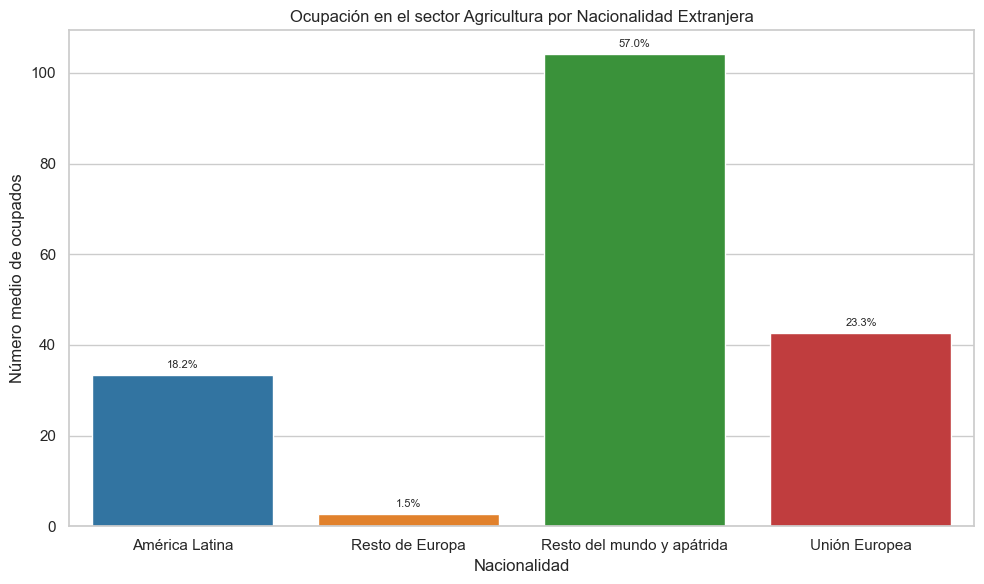

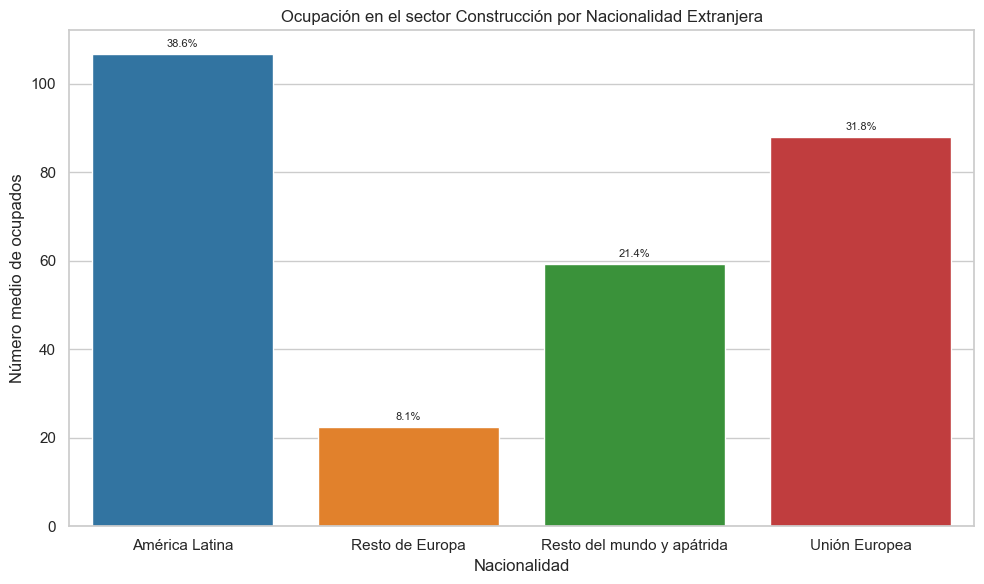

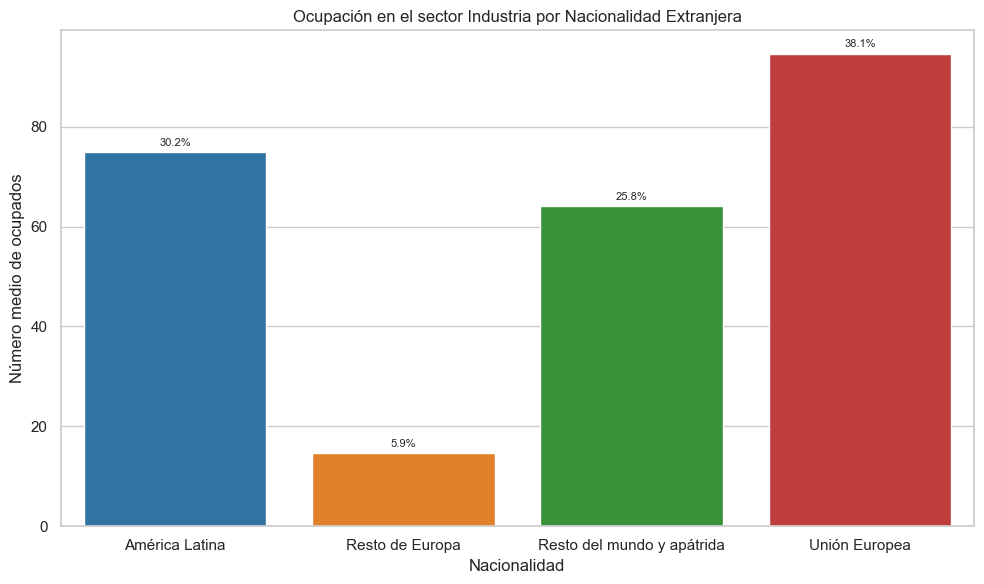

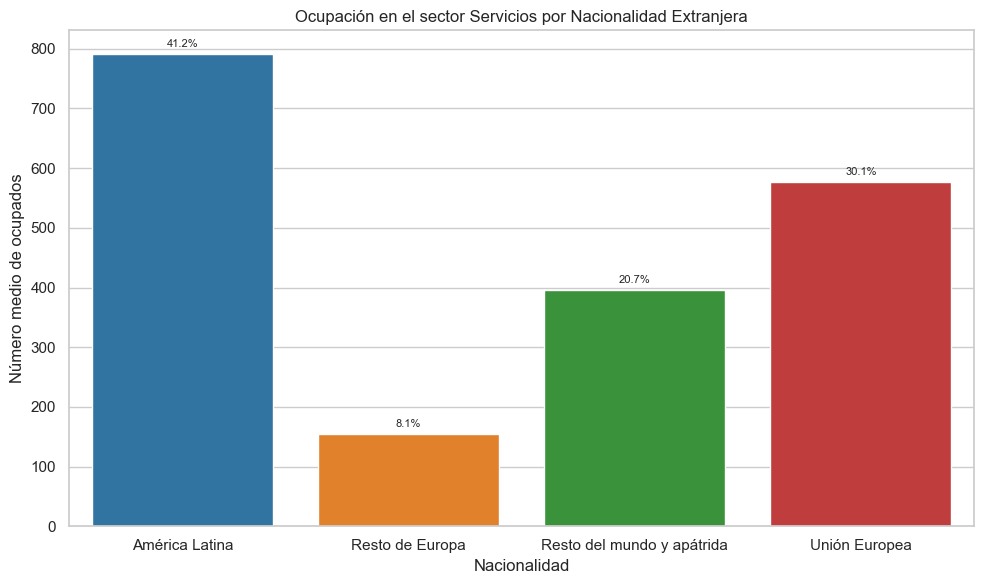

In [12]:
sectores_ocupacion = ["Agricultura", "Construcción", "Industria", "Servicios"]

for sector in sectores_ocupacion:
    data_sector = aggf[aggf["Sector económico"] == sector].copy()
    data_sector["Nacionalidad Simple"] = data_sector["Nacionalidad"].str.replace("Extranjera: ", "", regex=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=data_sector,
        x="Nacionalidad Simple",
        y="Total",
        hue="Nacionalidad Simple",
        palette="tab10",
        legend=False  # elimina leyenda duplicada
    )

    for bar, porcentaje in zip(ax.patches, data_sector["Porcentaje"]):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + data_sector["Total"].max() * 0.01,
            f"{porcentaje:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8
        )

    plt.title(f"Ocupación en el sector {sector} por Nacionalidad Extranjera")
    plt.xlabel("Nacionalidad")
    plt.ylabel("Número medio de ocupados")
    plt.tight_layout()
    plt.show()


## Tasa de Empleo por Nacionalidad

In [11]:
empleof = empleo.groupby(["Nacionalidad", "Periodo"])["Total"].mean().reset_index()


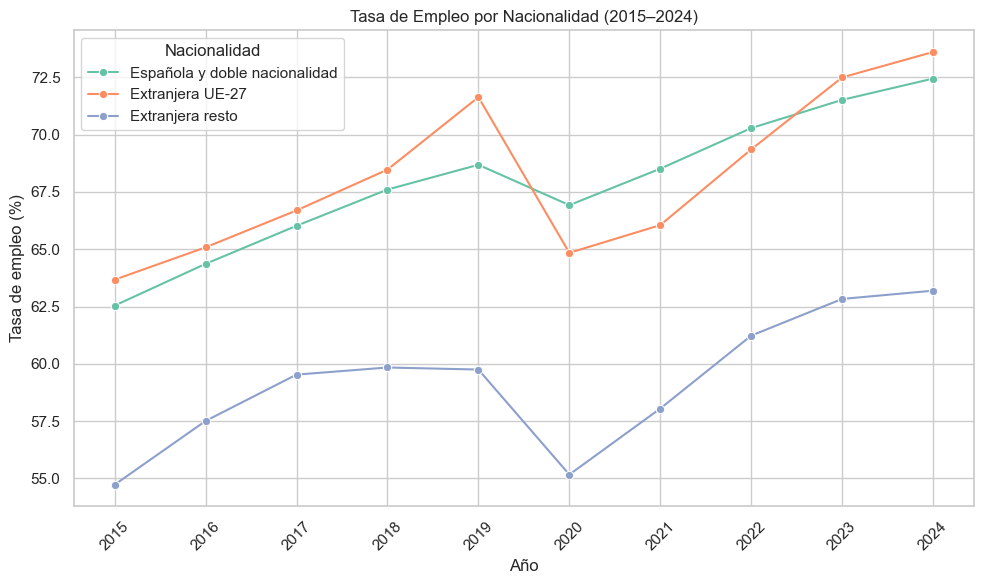

In [12]:
comparacion = empleof[empleof["Nacionalidad"] != "Total"]

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparacion, x="Periodo", y="Total", hue="Nacionalidad", marker="o", palette="Set2")

plt.title("Tasa de Empleo por Nacionalidad (2015–2024)")
plt.xlabel("Año")
plt.ylabel("Tasa de empleo (%)")
plt.xticks(comparacion["Periodo"].unique(), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Delitos por Nacionalidad

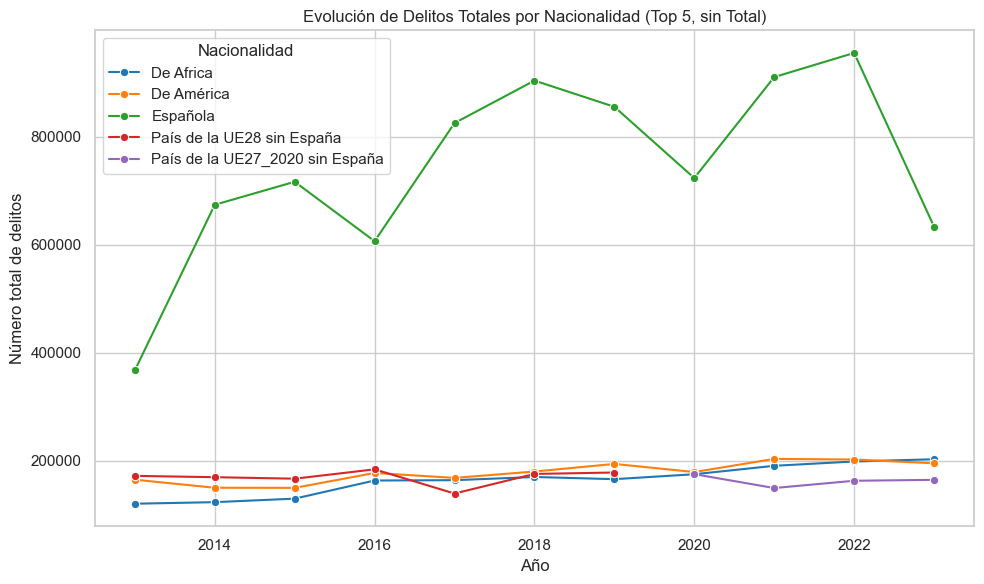

In [13]:
# 1. Limpiar datos: quitar nulos y ceros
delitos_filtrado = delitos[(delitos["Total"].notna()) & (delitos["Total"] > 0)]

# 2. Eliminar nacionalidad "Total"
delitos_filtrado = delitos_filtrado[delitos_filtrado["Nacionalidad"].str.lower() != "total"]

# 3. Calcular top 5 nacionalidades con más delitos
top_nac = (
    delitos_filtrado.groupby("Nacionalidad")["Total"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# 4. Filtrar por top 5 nacionalidades
delitos_top = delitos_filtrado[delitos_filtrado["Nacionalidad"].isin(top_nac)]

# 5. Agrupar por año y nacionalidad
del_por_año = (
    delitos_top.groupby(["Periodo", "Nacionalidad"])["Total"]
    .sum()
    .reset_index()
)

# 6. Graficar
plt.figure(figsize=(10, 6))
sns.lineplot(data=del_por_año, x="Periodo", y="Total",palette="tab10", hue="Nacionalidad", marker="o")
plt.title("Evolución de Delitos Totales por Nacionalidad (Top 5, sin Total)")
plt.xlabel("Año")
plt.ylabel("Número total de delitos")
plt.grid(True)
plt.tight_layout()
plt.show()


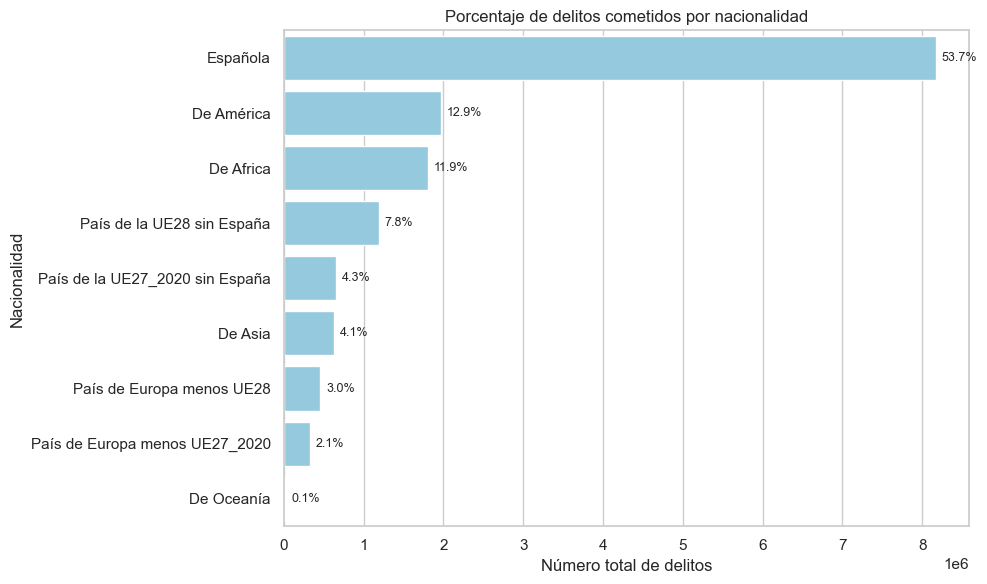

In [ ]:
# 1. Filtrar datos válidos (sin NaN ni 0)
delitos_limpios = delitos[(delitos["Total"].notna()) & (delitos["Total"] > 0)]

# 2. Agrupar y sumar por nacionalidad
agg_delitos = (
    delitos_filtrado.groupby("Nacionalidad")["Total"]
    .sum()
    .reset_index()
    .sort_values("Total", ascending=False)
)

# 3. Eliminar fila con "Total" como nacionalidad si existe
agg_delitos = agg_delitos[agg_delitos["Nacionalidad"].str.lower() != "total"]

# 4. Calcular top 10 y porcentaje
total_general = agg_delitos["Total"].sum()
top10 = agg_delitos.head(10).copy()
top10["Porcentaje"] = (top10["Total"] / total_general) * 100

# 5. Graficar
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10, x="Total", y="Nacionalidad", color="skyblue")

# 6. Agregar etiquetas con porcentaje
for i, (total, porcentaje) in enumerate(zip(top10["Total"], top10["Porcentaje"])):
    ax.text(total + total_general * 0.005, i, f"{porcentaje:.1f}%", va="center", fontsize=9)

plt.title("Porcentaje de delitos cometidos por nacionalidad")
plt.xlabel("Número total de delitos")
plt.ylabel("Nacionalidad")
plt.tight_layout()
plt.show()


## Salarios por Tipo de Jornada y Nacionalidad

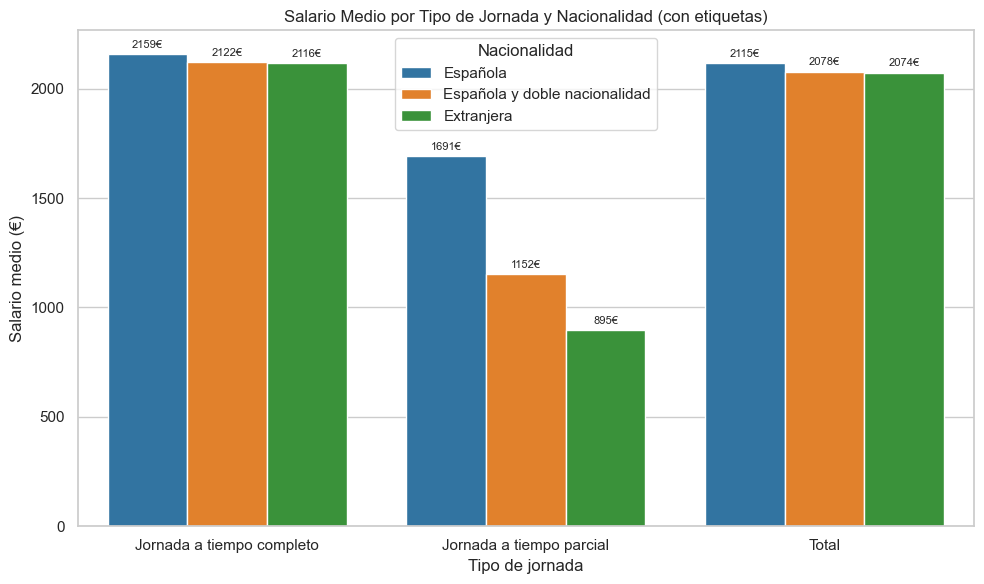

In [15]:
# 1. Filtrar para eliminar "Total" en Nacionalidad
salario_filtrado = salario[salario["Nacionalidad"].str.lower() != "total"]

# 2. Agrupar por jornada y nacionalidad
agg_salario = (
    salario_filtrado
    .groupby(["Tipo de jornada", "Nacionalidad"])["Total"]
    .mean()
    .reset_index()
)

# 3. Calcular porcentajes dentro de cada tipo de jornada
agg_salario["Porcentaje"] = agg_salario.groupby("Tipo de jornada")["Total"].transform(
    lambda x: (x / x.sum()) * 100
)

# 4. Graficar
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=agg_salario,
    x="Tipo de jornada",
    y="Total",
    hue="Nacionalidad",
    palette="tab10"
)

# 5. Añadir porcentaje como etiqueta sobre cada barra
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        jornada = ax.get_xticks()[int(x)]
        ax.text(
            x,
            height + 20,  # ajusta si las cifras son pequeñas o grandes
            f"{height:.0f}€",
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=0
        )

plt.title("Salario Medio por Tipo de Jornada y Nacionalidad (con etiquetas)")
plt.ylabel("Salario medio (€)")
plt.xlabel("Tipo de jornada")
plt.tight_layout()
plt.show()


## Delitos Sexuales por Nacionalidad (Top 10)

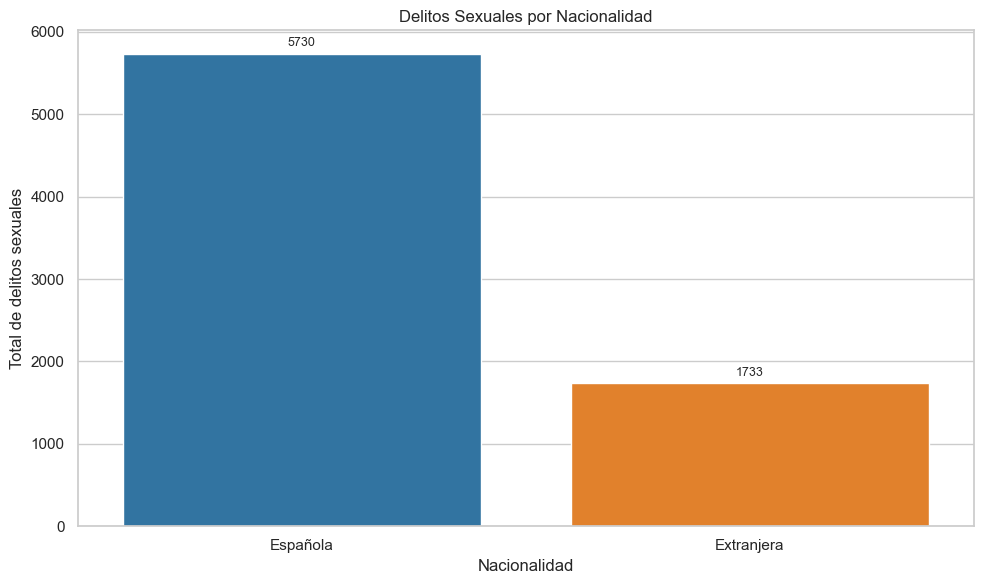

In [16]:
# 1. Filtrar y agrupar
dsexual_filtrado = delito_sexual[delito_sexual["Nacionalidad"].str.lower() != "total"]
agg_dsexual = (
    dsexual_filtrado.groupby("Nacionalidad")["Total"]
    .sum()
    .reset_index()
    .sort_values("Total", ascending=False)
)

# 2. Crear gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=agg_dsexual, x="Nacionalidad", y="Total", palette="tab10", hue="Nacionalidad", dodge=False)

# 3. Agregar etiquetas con los valores encima de las barras
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(agg_dsexual["Total"]) * 0.01,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=9
    )

# 4. Ajustes finales
plt.title("Delitos Sexuales por Nacionalidad")
plt.ylabel("Total de delitos sexuales")
plt.xlabel("Nacionalidad")
plt.legend([],[], frameon=False)  # Oculta leyenda duplicada
plt.tight_layout()
plt.show()


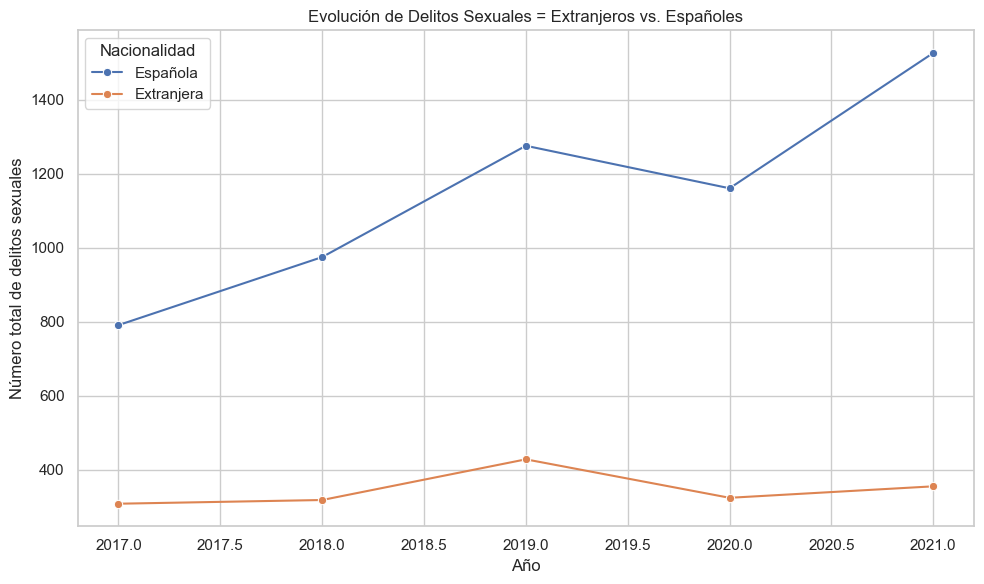

In [ ]:
agg_anual_ds = (
    dsexual_filtrado
    .groupby(["Periodo", "Nacionalidad"])["Total"]
    .sum()
    .reset_index()
)
plt.figure(figsize=(10, 6))
sns.lineplot(data=agg_anual_ds, x="Periodo", y="Total", hue="Nacionalidad", marker="o")
plt.title("Evolución de Delitos Sexuales = Extranjeros vs. Españoles")
plt.xlabel("Año")
plt.ylabel("Número total de delitos sexuales")
plt.grid(True)
plt.tight_layout()
plt.show()


## Jóvenes que no Estudian ni Trabajan (NEET)

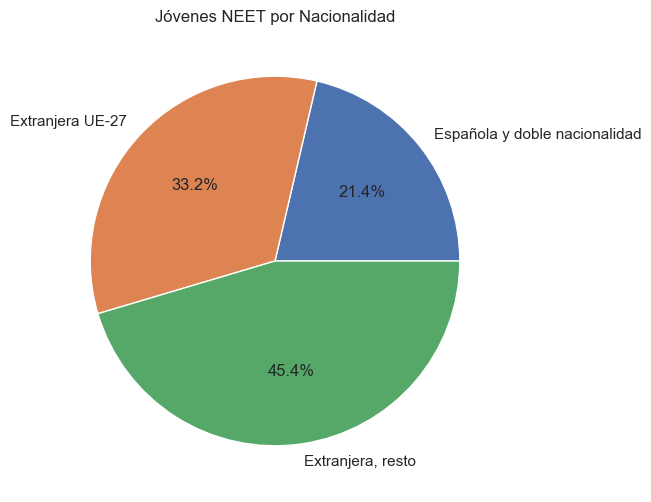

In [ ]:
agg_jneet = neet.groupby("Nacionalidad")["Total"].mean().reset_index()
plt.pie(agg_jneet["Total"], labels=agg_jneet["Nacionalidad"], autopct='%1.1f%%')
plt.title("Jóvenes nini por Nacionalidad")
plt.show()

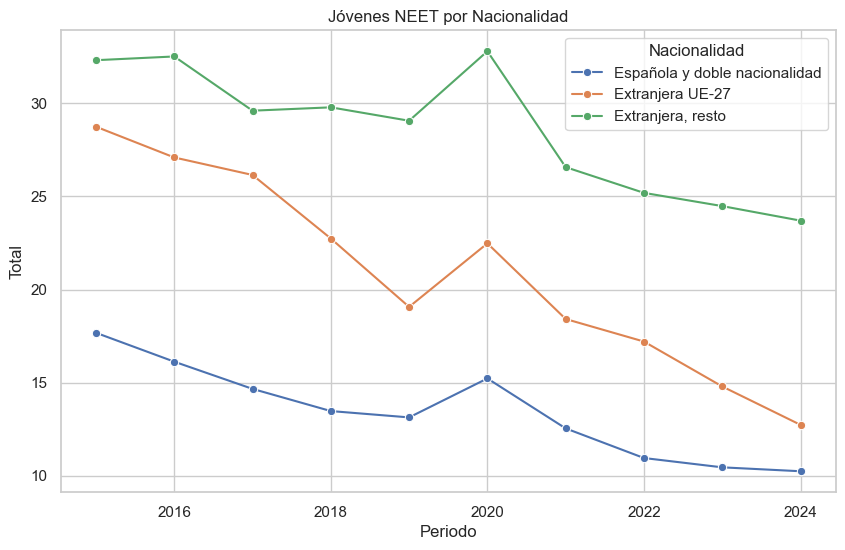

In [38]:
agg_janual = neet.groupby(["Periodo","Nacionalidad"])["Total"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=agg_janual, x="Periodo", y="Total", hue="Nacionalidad", marker="o")
plt.title("Jóvenes NEET por Nacionalidad")
plt.show()

## Paro por Nacionalidad

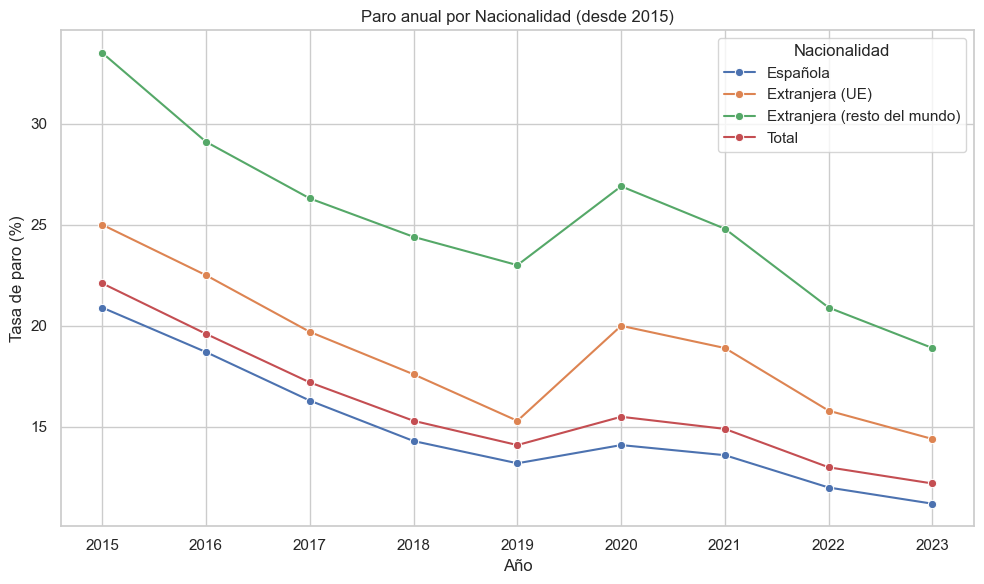

In [47]:
# Asegurar que 'periodo' es numérico
paro["periodo"] = pd.to_numeric(paro["periodo"], errors="coerce")

# Filtrar años desde 2015
paro_anual = paro.groupby(["periodo", "Nacionalidad"])["Total"].mean().reset_index()
paro_filtrado = paro_anual[paro_anual["periodo"] >= 2015]

# Graficar
plt.figure(figsize=(10, 6))
sns.lineplot(data=paro_filtrado, x="periodo", y="Total", hue="Nacionalidad", marker="o")
plt.title("Paro anual por Nacionalidad (desde 2015)")
plt.xlabel("Año")
plt.ylabel("Tasa de paro (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


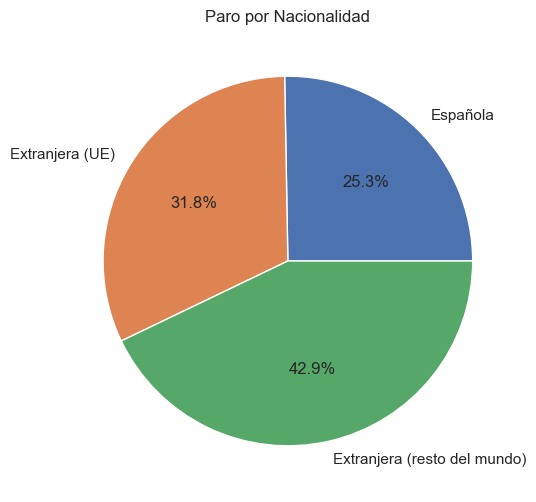

In [46]:
paro_filtro = paro_filtrado[paro_filtrado["Nacionalidad"].str.lower() != "total"]
agg_paro = paro_filtro.groupby("Nacionalidad")["Total"].mean().reset_index()
plt.pie(agg_paro["Total"], labels=agg_paro["Nacionalidad"], autopct='%1.1f%%')
plt.title("Paro por Nacionalidad")
plt.show()

## Riesgo de Pobreza por Nacionalidad

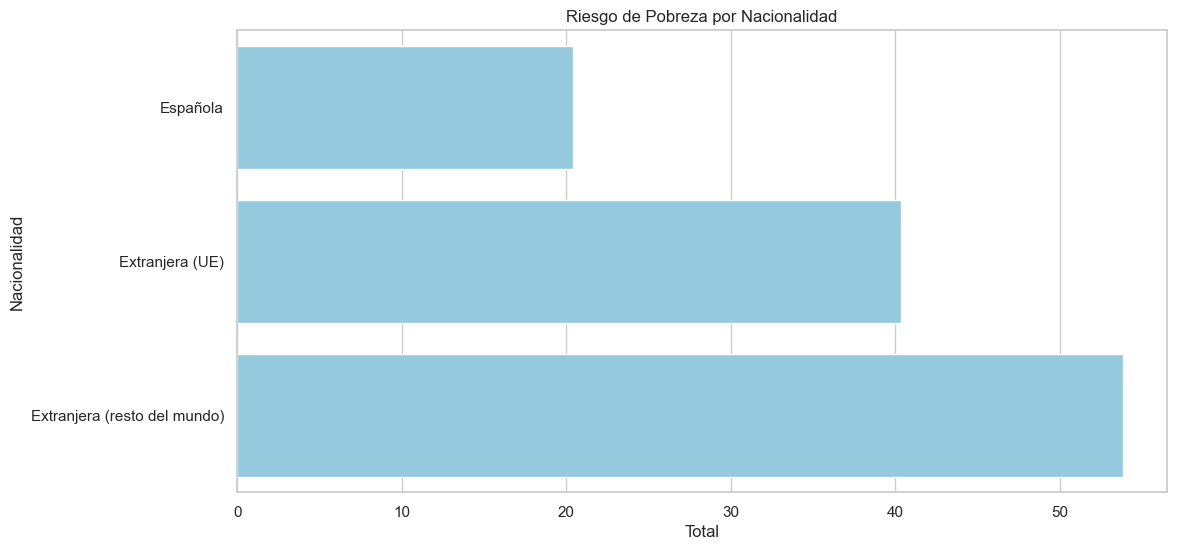

In [50]:
pobreza_filtro = pobreza[pobreza["Nacionalidad"].str.lower() != "total"]
agg_pobreza = pobreza_filtro.groupby("Nacionalidad")["Total"].mean().reset_index()
sns.barplot(data=agg_pobreza, x="Total", y="Nacionalidad",color='skyblue')
plt.title("Riesgo de Pobreza por Nacionalidad")
plt.show()

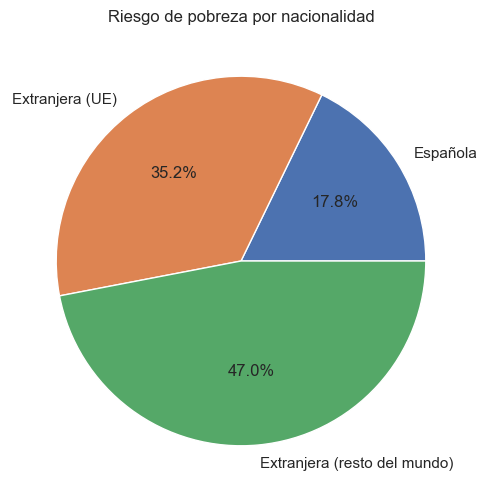

In [52]:
plt.pie(agg_pobreza["Total"], labels=agg_pobreza["Nacionalidad"], autopct='%1.1f%%')
plt.title("Riesgo de pobreza por nacionalidad")
plt.show()